In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import glob
from radical.entk import Profiler
import radical.analytics as ra
import radical.utils as ru
import radical.pilot as rp
import numpy as np
import math


pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline
help(rp.states)



Help on module radical.pilot.states in radical.pilot:

NAME
    radical.pilot.states

FILE
    /Users/JumanaDakka/environments/venv/lib/python2.7/site-packages/radical/pilot/states.py

DATA
    AGENT_EXECUTING = 'AGENT_EXECUTING'
    AGENT_EXECUTING_PENDING = 'AGENT_EXECUTING_PENDING'
    AGENT_SCHEDULING = 'AGENT_SCHEDULING'
    AGENT_SCHEDULING_PENDING = 'AGENT_SCHEDULING_PENDING'
    AGENT_STAGING_INPUT = 'AGENT_STAGING_INPUT'
    AGENT_STAGING_INPUT_PENDING = 'AGENT_STAGING_INPUT_PENDING'
    AGENT_STAGING_OUTPUT = 'AGENT_STAGING_OUTPUT'
    AGENT_STAGING_OUTPUT_PENDING = 'AGENT_STAGING_OUTPUT_PENDING'
    CANCELED = 'CANCELED'
    DONE = 'DONE'
    FAILED = 'FAILED'
    FINAL = ['DONE', 'FAILED', 'CANCELED']
    INITIAL = ['NEW']
    NEW = 'NEW'
    PMGR_ACTIVE = 'PMGR_ACTIVE'
    PMGR_ACTIVE_PENDING = 'PMGR_ACTIVE_PENDING'
    PMGR_LAUNCHING = 'PMGR_LAUNCHING'
    PMGR_LAUNCHING_PENDING = 'PMGR_LAUNCHING_PENDING'
    UMGR_SCHEDULING = 'UMGR_SCHEDULING'
    UMGR_SCHEDULING_PENDING

In [20]:
# Generate task uids

def get_task_uids(num_pipelines):
    
    num_tasks = 2
    task_uids = []
    for t in range(num_tasks):
        task_uids.append('radical.entk.task.%04d'%t)

    return task_uids

In [21]:
# Get information from all the htbac profiles

# Create workflow runner and execution_run measures
# duration between creating runner object and before .run()

def get_htbac_info(pipelines,t):
    
    htbac_files = glob.glob('./ties_{}_instances_run_{}/radical.htbac.*'.format(pipelines,t)) 
    for file in htbac_files:
        if file.endswith('workflow_runner.0000.prof'):
            workflow_runner = file
            for line in open(workflow_runner).readlines():
                if "create workflow_runner" in line:
                    initial_time = float(line.split(',')[0])
                if "execution_run" in line:
                    final_time = float(line.split(',')[0])
            runner_overhead = final_time - initial_time  
    return runner_overhead      

In [22]:

# Get information from all the entk profiles

def get_entk_info(pipelines,t):
    
    p = Profiler(src = './ties_{}_instances_run_{}'.format(pipelines,t))
    
    task_uids = get_task_uids(pipelines)
    
    entk_dur = p.duration(task_uids, states=['SCHEDULING','DONE'])
    
    # Time taken in appmanager to rreq function call
    entk_core_1 = p.duration('radical.entk.appmanager.0000', events=['create amgr obj', 'init rreq submission'])
    
    # Time taken to tear down appmanager
    entk_core_2 = p.duration('radical.entk.appmanager.0000', events=['start termination', 'termination done'])
    
    # Time taken to create resource manager obj
    entk_core_3 = p.duration('radical.entk.resource_manager.0000', events = ['create rmgr obj', 'rmgr obj created'])
    
    # Time taken to create and submit resource reservation
    entk_core_4 = p.duration('radical.entk.resource_manager.0000', events = ['creating rreq', 'rreq submitted'])
    
    # Time taken to deallocate resource reservation time to cancel pilot
    #entk_core_5 = p.duration('radical.entk.resource_manager.0000', events = ['canceling resource allocation', 'resource allocation cancelled'])
    
    
    #entk_dur = entk_core_1 (entk setup time) + entk_core_4 (time to create and launch pilot) + entk_core_5 (time to cancel pilot) + p.duration('radical.entk.appmanager.0000', events=['starting synchronizer thread','termination done'])
    
    entk_dur = entk_core_1 + entk_core_4 + p.duration('radical.entk.appmanager.0000', 
                                                      events=['starting synchronizer thread','start termination'])
    
    entk_core_dur = entk_core_1 + entk_core_2 + entk_core_3 
    
    #entk_total_dur = entk_dur_1 + entk_dur_2 + entk_core_dur
    
    return entk_dur

In [44]:
# Get information from all the rp profile files and json file
# returns 0,0 if no rp files are found

def get_rp_info(pipelines,t):

    rp_folder = glob.glob('./ties_{}_instances_run_{}/rp.*'.format(pipelines,t))
    src = rp_folder[0]
    session = ra.Session(stype='radical.pilot', src=src)
    events = session.list('event')
    #print events
    units = session.filter(etype='unit', inplace=False)
    pilots = session.filter(etype='pilot', inplace=False)
    durations=list()
    #for unit in units.get():
    #    exec_duration = unit.duration(event=[{ru.EVENT: 'cu_exec_start'},
     #                                       {ru.EVENT: 'cu_exec_stop'}])
        
      #  durations.append(exec_duration)
    #cu_dur = sum(durations) / len(durations)
    #print cu_dur
    exec_dur = units.duration([rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING])
    rp_dur = pilots.duration([rp.PMGR_ACTIVE, rp.FINAL])
    task_exec_dur = []
    get_units = session.get(etype='unit')
    #print len(get_units)
    
    #assert len(get_units) == pipeline*4

    sorted_units = sorted(units.list('uid'))
    # print sorted_units

    
    
    '''
    for x in range(0, pipeline*8, pipeline):
    #   print x
    #   print x + pipeline
    #   print sorted_units[x:x+pipeline]
        session = ra.Session(stype='radical.pilot', src=src)
        subset_units = session.filter(uid=sorted_units[x:x+pipeline])
        exec_dur = subset_units.duration([rp.AGENT_EXECUTING, rp.DONE])
        task_exec_dur.append(exec_dur)
        
    '''
    return rp_dur, exec_dur


In [45]:
df = pd.DataFrame(columns=['EnTK overhead', 'RP overhead', 'HTBAC overhead','Execution duration'])
df_err = pd.DataFrame(columns=['EnTK overhead', 'RP overhead', 'HTBAC overhead','Execution duration'])
#df_cu_dur = pd.DataFrame(columns=['CU Durations'])
pipelines_list = [2,4,8,16]
trials = 1

for pipelines in pipelines_list:
    
    entk_ov_list = list()
    rp_ov_list   = list()
    exec_list    = list()
    htbac_list   = list()
    
    for t in range(1,trials+1):
        entk_dur = get_entk_info(pipelines,t)
        rp_dur, exec_dur = get_rp_info(pipelines,t)
        htbac_overhead = get_htbac_info(pipelines,t)
        #print exec_dur
        #print htbac_overhead

        temp_entk_dur = entk_dur - rp_dur
        temp_rp_dur   = rp_dur - exec_dur
        temp_exec_dur = exec_dur
        
        entk_ov_list.append(temp_entk_dur)
        rp_ov_list.append(temp_rp_dur)
        exec_list.append(temp_exec_dur)
        htbac_list.append(htbac_overhead)
    
    
    df.loc[pipelines] = [np.average(entk_ov_list),
                         np.average(rp_ov_list),
                         np.average(htbac_list),
                         np.average(exec_list)]
    
    df_err.loc[pipelines] = [np.std(entk_ov_list)/math.sqrt(trials),
                             np.std(rp_ov_list)/math.sqrt(trials),
                             np.std(htbac_list)/math.sqrt(trials),
                             np.std(exec_list)/math.sqrt(trials)]

#df.insert['CU duration'] = [503.675074616, 503.089954421, 498.984711251]

df   


TypeError: 'instancemethod' object does not support item assignment

In [ ]:
%matplotlib inline

In [11]:
'''
ax = df.plot(kind='bar', title='Time taken by EnTK and RP to execute a workflow consisting of \n X Pipelines, 7 Stages per Pipeline and 1 Task per Stage on NCSA.BW (Task executable = "sleep 0", number of trials per data point = 1)')
ax.set_xlabel('Number of Pipelines')
ax.set_ylabel('Time (seconds)')


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('null_worload_devel.pdf', dpi=100)
'''

u'\nax = df.plot(kind=\'bar\', title=\'Time taken by EnTK and RP to execute a workflow consisting of \n X Pipelines, 7 Stages per Pipeline and 1 Task per Stage on NCSA.BW (Task executable = "sleep 0", number of trials per data point = 1)\')\nax.set_xlabel(\'Number of Pipelines\')\nax.set_ylabel(\'Time (seconds)\')\n\n\nfig = plt.gcf()\nfig.set_size_inches(18.5, 10.5)\nfig.savefig(\'null_worload_devel.pdf\', dpi=100)\n'

In [46]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)    
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

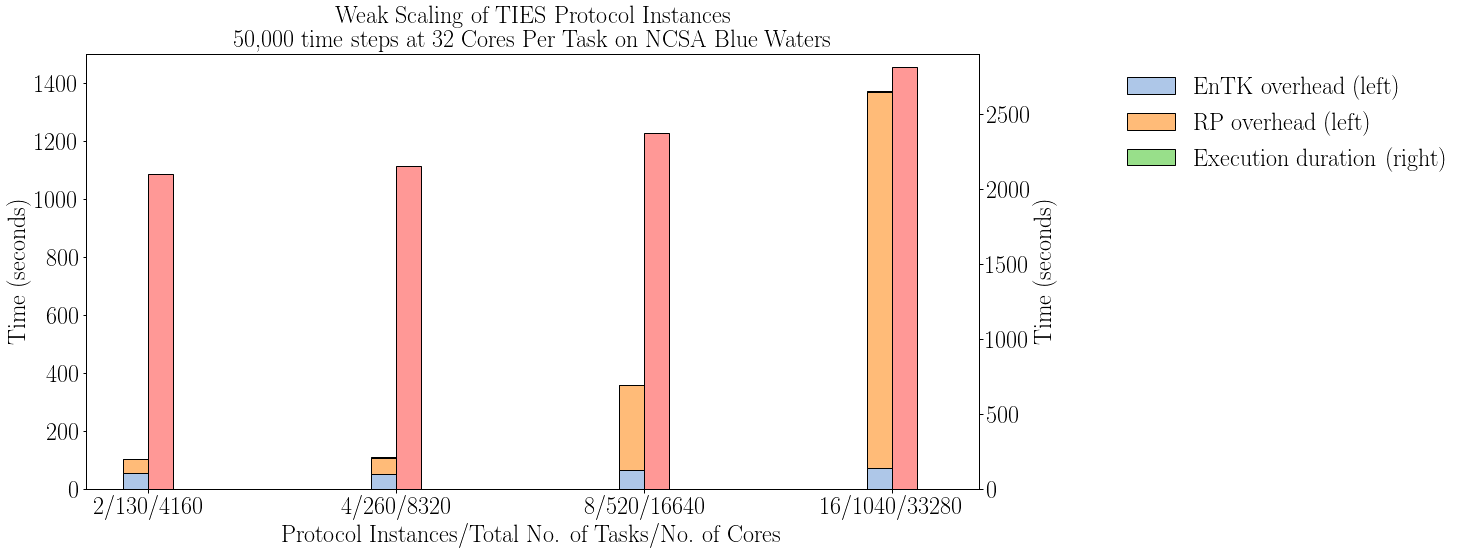

In [56]:
fig, ax = fig_setup()

ov_err = df_err
columns = ['Execution duration']

width=0.1
ax = df.plot(kind='bar', stacked=True, 
             ax=ax,
             #y=df.drop(columns),
             #y=df.drop(columns, axis=1),
             y=df.columns.drop(columns),
             yerr=ov_err,
             fontsize=SIZE,
             width=width,
             position=1,
             color = [tableau20[(1)], tableau20[(3)],tableau20[5]],
             title='Weak Scaling of TIES Protocol Instances \n 50,000 time steps at 32 Cores Per Task on NCSA Blue Waters',
             legend=False)


ax2 = df['Execution duration'].plot(ax=ax, stacked=True, secondary_y=True, color = [tableau20[(7)]],              
                        width=width, 
                        yerr=ov_err,
                        legend=False, 
                        position=0, kind = 'bar')
ax2.set_ylim(0,2900)

ax.set_ylim(0,1500)
ax.set_xlabel('Protocol Instances/Total No. of Tasks/No. of Cores', fontsize=SIZE, )
ax.set_ylabel('Time (seconds)', fontsize=SIZE)
ax2.set_ylabel('Time (seconds)', fontsize=SIZE)
ax.set_title(ax.get_title(), fontsize=SIZE)
ax.set_xticklabels(['2/130/4160', '4/260/8320', '8/520/16640', '16/1040/33280'])
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels() 

labels = list()
labels += [l1[0] + ' (left)'] 
labels += [l1[1] + ' (left)']
#labels += [l1[2] + ' (left)']
labels += [l2[0] + ' (right)']

handles = h1 + h2
plt.legend(handles,labels,fontsize=SIZE, bbox_to_anchor = (1.55,1))
plt.show()
fig.savefig('weak_scaling_TIES_instances_50,000_timesteps_with_16_instances.pdf', dpi=100, bbox_inches='tight')